### Symplectic Neural Network and DeepONet for prediction of harmonic oscillator

In [144]:
# Libraries used
import torch
import matplotlib.pyplot as plt
from torch.autograd import grad
from math import pi as PI

In [145]:
# Reload when updating utils
from importlib import reload
from utils import DeepONet, SNN, Model, plot_utils
reload(DeepONet)
reload(SNN)
reload(Model)
reload(plot_utils)
from utils.DeepONet import DeepONet
from utils.DeepONet import DeepONet_rollout
from utils.SNN import *
from utils.Model import Model
from utils.plot_utils import *

In [146]:
def analytic_solution(iv, t, w=1):
    """Get analytical solution of the BVP for inital values and times"""
    p0 = iv[:,None,0] 
    q0 = iv[:,None,1] 
    p = p0 @ torch.cos(w * t).T - (q0 @ torch.sin(w * t).T) * w
    q = q0 @ torch.cos(w * t).T + (p0 @ torch.sin(w * t).T) / w
    return torch.stack((p, q), dim=-1)

def get_data(T, num_iv=10, num_t=10):
    
    # Generate inital values
    r = torch.sqrt(torch.rand(size=(num_iv, 1), dtype=torch.float32))
    theta = torch.rand(size=(num_iv, 1), dtype=torch.float32) * 2 * PI

    p = r * torch.cos(theta)
    q = r * torch.sin(theta)
        
    iv = torch.concat((p, q), axis=-1)
    
    
    if num_t > 1:
        # Random time generation if num_t > 1
        t = T * torch.rand(size=(num_t,1), dtype=torch.float32)
    else:
        # Otherwise deterministic
        t = torch.tensor([T], dtype=torch.float32)[:,None]

    y = analytic_solution(iv, t).squeeze()
    X = (iv, t)
    
    return X, y

TRAIN MODEL AND PLOT LOSS HISTORY

In [147]:
# # Whether to use rollout prediction
# # This affects data going in to X

test_intervals = False
if test_intervals:
    seeds = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
    Ts = [1, 5, 10, 15, 20, 25, 30]
    vloss, tloss, vtemp, ttemp = [], [], [], []

    for T in Ts:
        
        for seed in seeds:
            torch.manual_seed(seed)

            print(f'T={T}, seed: {seed}')
            
            X_train, y_train = get_data(T, num_iv=10, num_t=10)
            X_test, y_test = get_data(T, num_iv=10, num_t=10)
            net = DeepONet([32, 32, 32], [32, 32, 32], dim=2, K=2, activation='tanh', scheme=None)

            model = Model(X_train, y_train, X_test, y_test, net)
            model.train(iterations=15_000, verbose=False)
            ttemp.append(model.besttloss)
            vtemp.append(model.bestvloss)
            # model.plot_losshistory()
        
        vloss.append(torch.tensor(vtemp).mean())
        tloss.append(torch.tensor(ttemp).mean())
        
    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

    ax.plot(Ts, vloss, c='tab:green', label='Validation')
    ax.plot(Ts, torch.tensor(tloss).detach().numpy(), c='tab:blue', label='Training')

    ax.set_yscale('log')
    ax.set_xticks(Ts)

    ax.set_xlabel('Max Time')
    ax.set_ylabel('Loss')

    ax.legend(loc='upper left', fontsize=20)

    ax.grid(True)

    plt.show()

In [ ]:
# Maximal time and time-step for rollouts
T, Tmax, h = 5, 35, 1e-3

# Whether to use rollout prediction
# This affects data going in to X
rollout = False

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
models = []

for seed in seeds:
    torch.manual_seed(seed)

    if rollout:
        (iv_train, _), y_train = get_data(h, num_iv=10, num_t=1)
        (iv_test, _), y_test = get_data(h, num_iv=10, num_t=1)
        X_train = (iv_train[...,None,0], iv_train[...,None,1])
        X_test = (iv_test[...,None,0], iv_test[...,None,1])
    
        #net = SNN1D(3, [10,10,10], h, activation='tanh')
        net = vRO([2, 32, 32, 32, 2], activation='tanh', h=h)
        #net = QFIPRO([2, 32, 32, 32, 2], activation='tanh', h=h)
        
        loss = lambda x, y : torch.nn.MSELoss()(x, y) / h**2
        

    else:
        X_train, y_train = get_data(T, num_iv=10, num_t=10)
        X_test, y_test = get_data(T, num_iv=10, num_t=10)
        net = DeepONet([32, 32, 32], [32, 32, 32], dim=2, K=2, activation='tanh', scheme=None)
        
        loss = torch.nn.MSELoss()

    model = Model(X_train, y_train, X_test, y_test, net, loss=loss)
    model.train(iterations=15_000)
    
    models.append(model)

Step 	 Train loss 	 Test loss
100 	 [5.80e-02] 	 [7.66e-02] 	 New best model!
200 	 [1.11e-03] 	 [6.77e-03] 	 New best model!
300 	 [5.41e-04] 	 [4.49e-03] 	 New best model!
400 	 [2.84e-04] 	 [3.55e-03] 	 New best model!
500 	 [6.41e-05] 	 [3.22e-03] 	 New best model!
600 	 [3.36e-05] 	 [3.19e-03] 	 New best model!
700 	 [2.06e-05] 	 [3.14e-03] 	 New best model!
800 	 [1.35e-05] 	 [3.05e-03] 	 New best model!
900 	 [9.45e-06] 	 [3.06e-03] 	 
1000 	 [5.13e-06] 	 [3.06e-03] 	 
1100 	 [3.92e-06] 	 [3.01e-03] 	 New best model!
1200 	 [2.72e-06] 	 [3.05e-03] 	 
1300 	 [2.97e-06] 	 [2.98e-03] 	 New best model!
1400 	 [1.72e-06] 	 [2.99e-03] 	 
1500 	 [9.30e-06] 	 [3.05e-03] 	 
1600 	 [1.26e-06] 	 [3.03e-03] 	 
1700 	 [9.61e-07] 	 [3.04e-03] 	 
1800 	 [1.97e-06] 	 [3.03e-03] 	 
1900 	 [1.16e-06] 	 [3.06e-03] 	 
2000 	 [1.47e-06] 	 [3.07e-03] 	 
2100 	 [2.84e-06] 	 [3.05e-03] 	 
2200 	 [1.40e-06] 	 [3.07e-03] 	 
2300 	 [1.90e-06] 	 [3.07e-03] 	 
2400 	 [6.58e-07] 	 [3.08e-03] 	 
2500 	 [2.28e

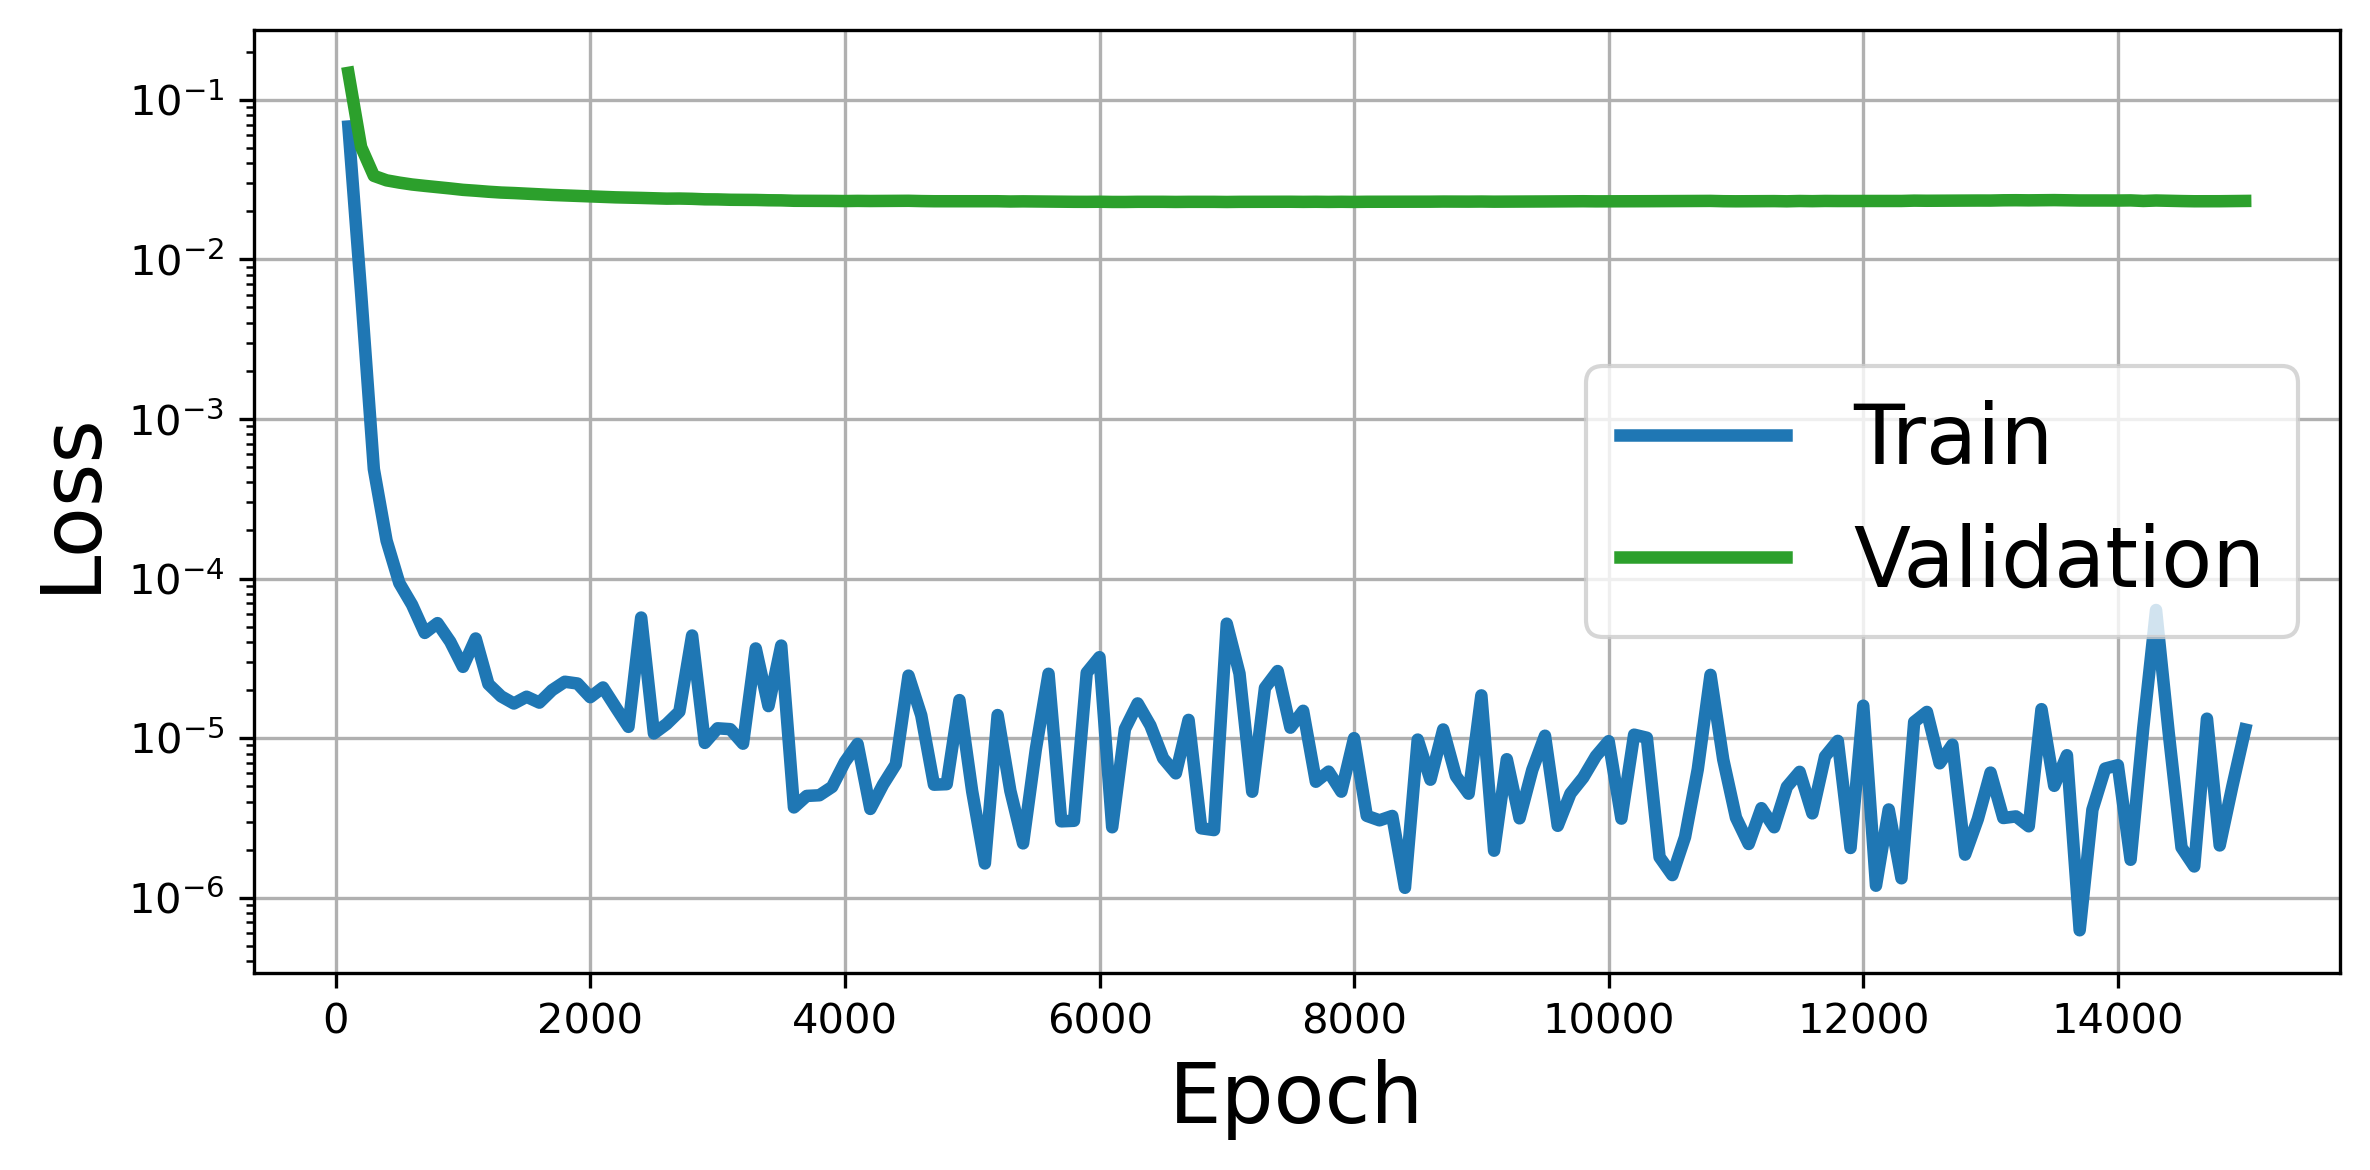

In [149]:
plot_histories(models)

In [150]:
num_pts = 100

torch.manual_seed(10)
    
r = torch.sqrt(torch.rand(size=(num_pts, 1), dtype=torch.float32))
theta = torch.rand(size=(num_pts, 1), dtype=torch.float32) * 2 * PI

p = r * torch.cos(theta)
q = r * torch.sin(theta)

iv = torch.cat((p, q), axis=-1)
    
preds = torch.tensor([])

for i, model in enumerate(models[:1]):
    
    print(f'running model {i+1}...')

    if rollout:
        pred = predict_rollout(model.net, (iv[...,None,0], iv[...,None,1]), Tmax, h)        
        
        
    else:
        pred = DeepONet_rollout(model.net, iv, Tmax, T, h)
                
            
    # Energy of prediction
    preds = torch.cat((preds, pred[None,:]))

running model 1...


torch.Size([1, 100, 35001, 2])


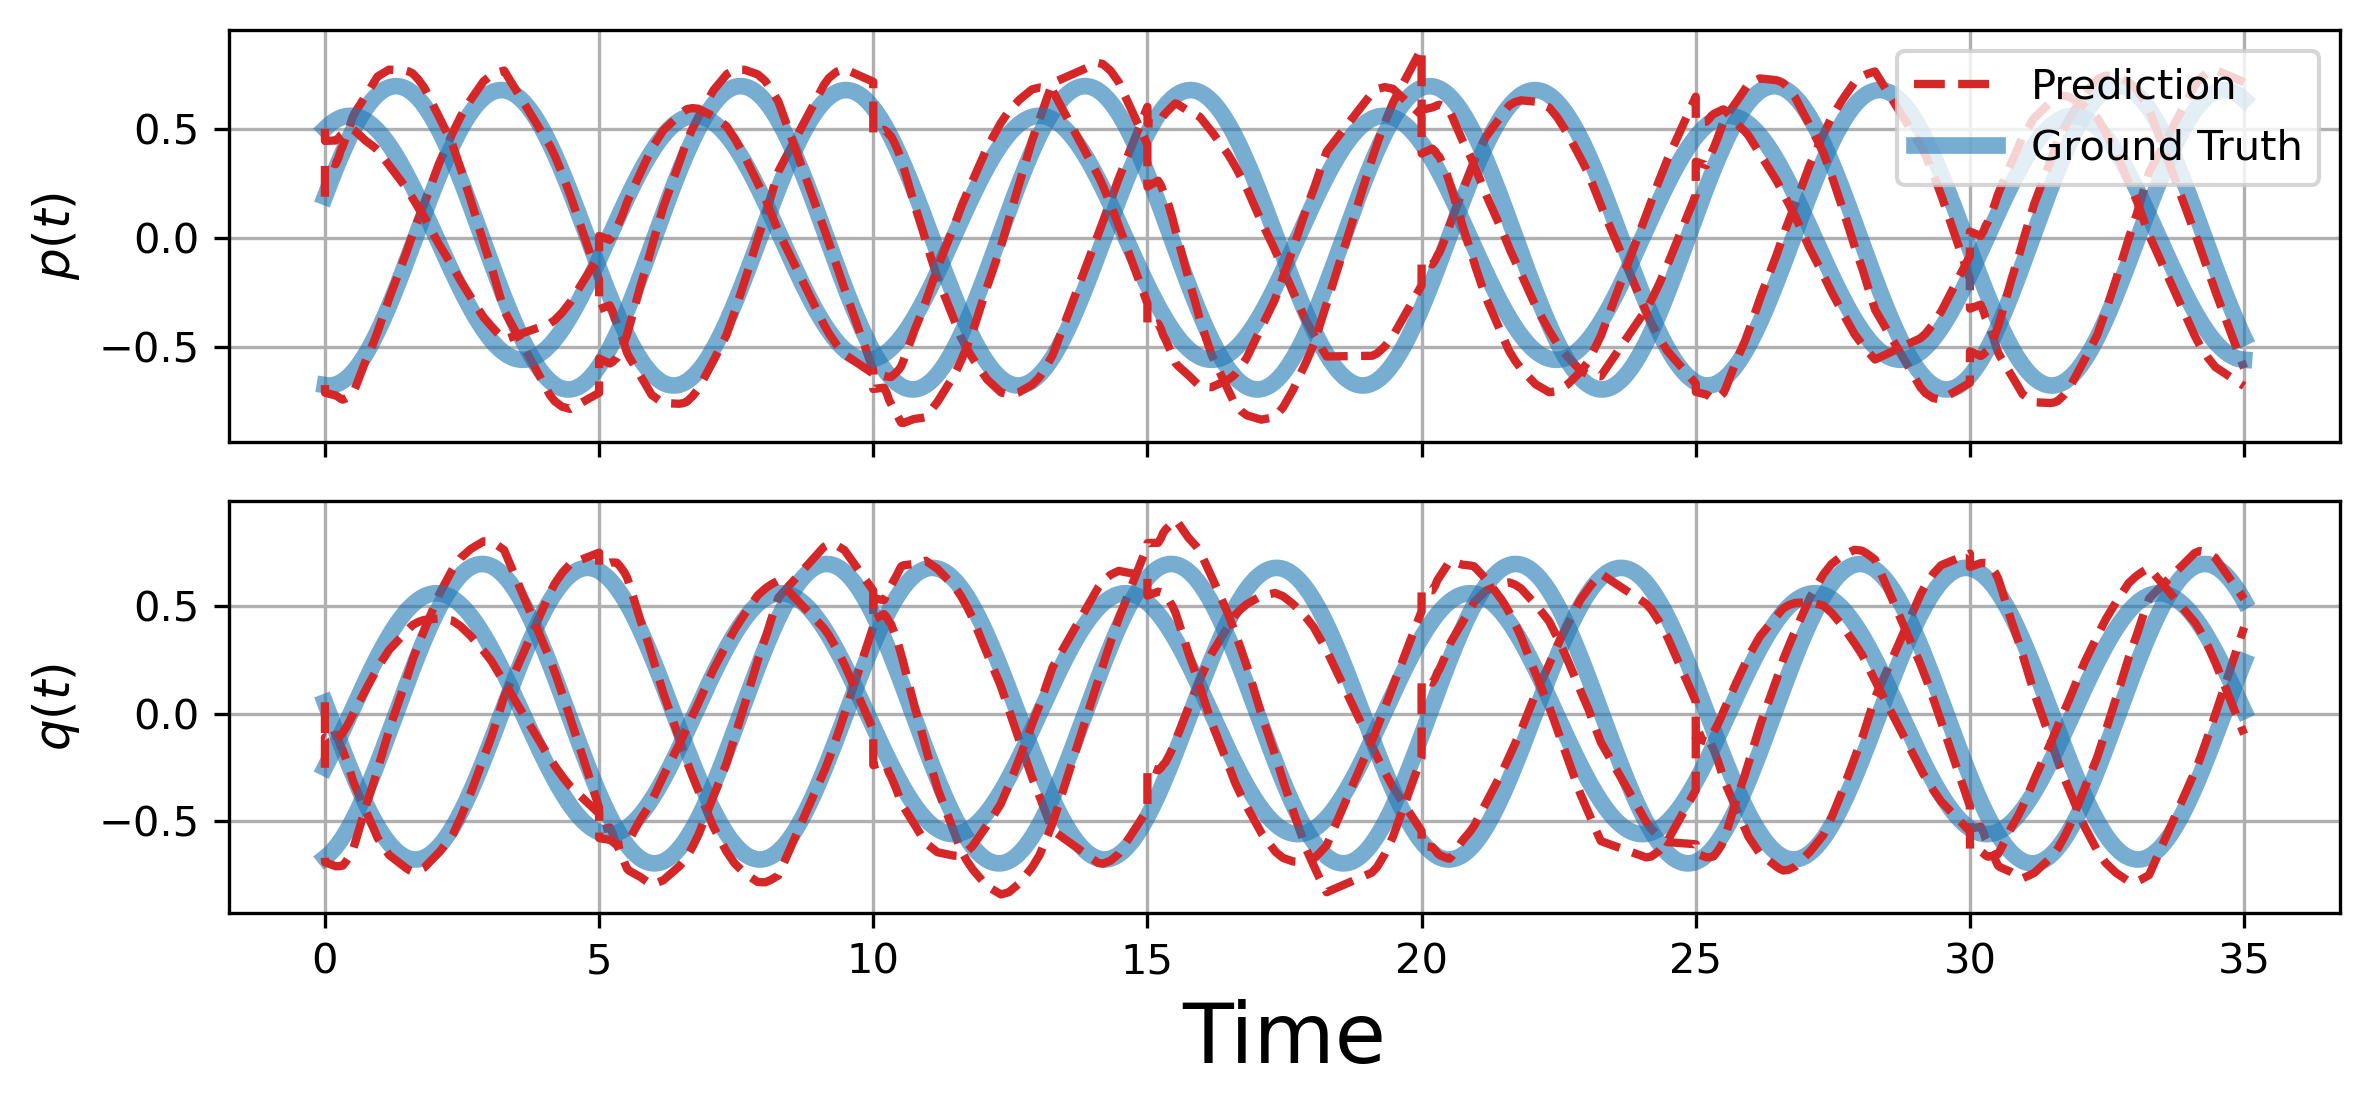

In [151]:
Tmax = 35
t = torch.linspace(0, Tmax, int(Tmax / h)+1, dtype=torch.float32)
true = analytic_solution(iv, t[:,None])

print(preds.shape)

plot_predictions(preds[0,:3,...], true[:3,...], t, dpi=300)

PLOT ENERGY OF PREDICTIONS

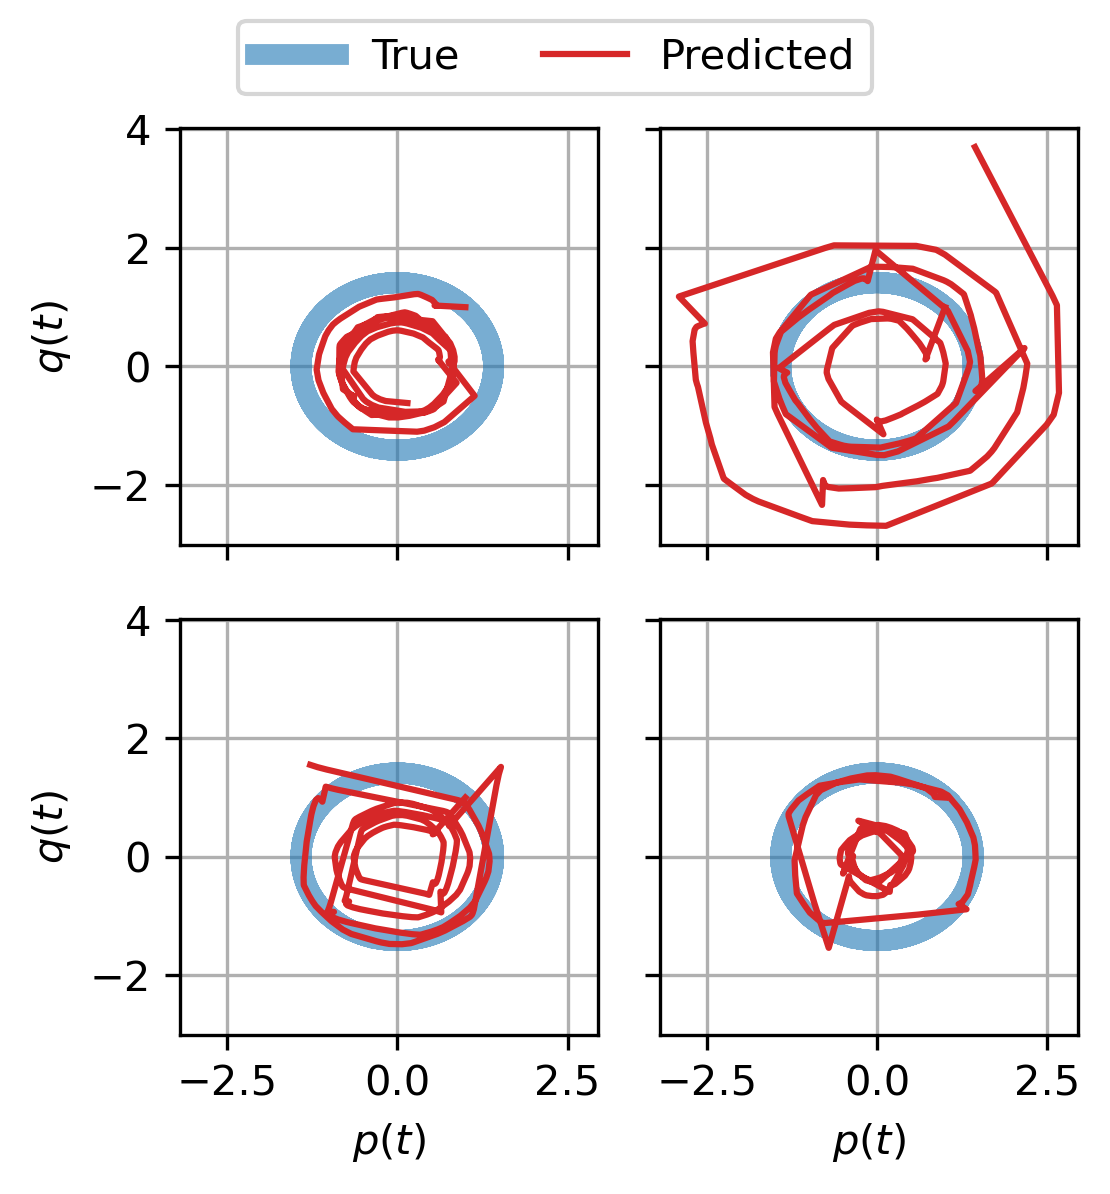

In [152]:
import matplotlib.pyplot as plt
import torch

def plot_phase_space(p=1, q=1, dpi=300):
    """Plot the energy of the system (Hamiltonian) as time progresses"""

    fig, ax = plt.subplots(2, 2, figsize=(4, 4), dpi=dpi, sharex=True, sharey=True)
    
    t_full = torch.linspace(0, Tmax, int(Tmax / h) + 1, dtype=torch.float32)[1:]
    
    iv = torch.tensor([[p, q]], dtype=torch.float32)
    
    # Store one legend item only
    handles, labels = None, None
    
    for row in range(ax.shape[0]):
        for col in range(ax.shape[1]):
            idx = row * 2 + col
            net = models[idx].net

            if rollout:
                u = predict_rollout(net, (iv[...,None,0], iv[...,None,1]), Tmax, h)
                
                
            else:
                u = DeepONet_rollout(net, iv, Tmax, T, h)

            # Predicted phase space
            p_pred, q_pred = u[0, :, 0], u[0, :, 1]

            # Analytical solution
            analytical = analytic_solution(iv, t_full[:, None], w=1)
            p_true, q_true = analytical[0, :, 0], analytical[0, :, 1]

            ax[row, col].plot(p_true.detach(), q_true.detach(), c='tab:blue', alpha=0.6, linewidth=5, label='True')
            ax[row, col].plot(p_pred.detach(), q_pred.detach(), c='tab:red', alpha=1, linewidth=1.5, label='Predicted')

            # Only add ylabel to left-most plots
            #if col == 1:
            #    ax[row, col].set_yticklabels([])
            ax[row, col].grid(True)
            
            if row == 1:
                ax[row, col].set_xlabel('$p(t)$')
            
            if col == 0:
                ax[row, col].set_ylabel('$q(t)$')

            # Save handles and labels for legend from the first plot
            if row == 0 and col == 0:
                handles, labels = ax[row, col].get_legend_handles_labels()

    # Shared legend
    if handles and labels:
        fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10)

    plt.tight_layout(rect=[0.05, 0.0, 1, 0.95])  # Adjust for shared labels/legend
    plt.show()

plot_phase_space()


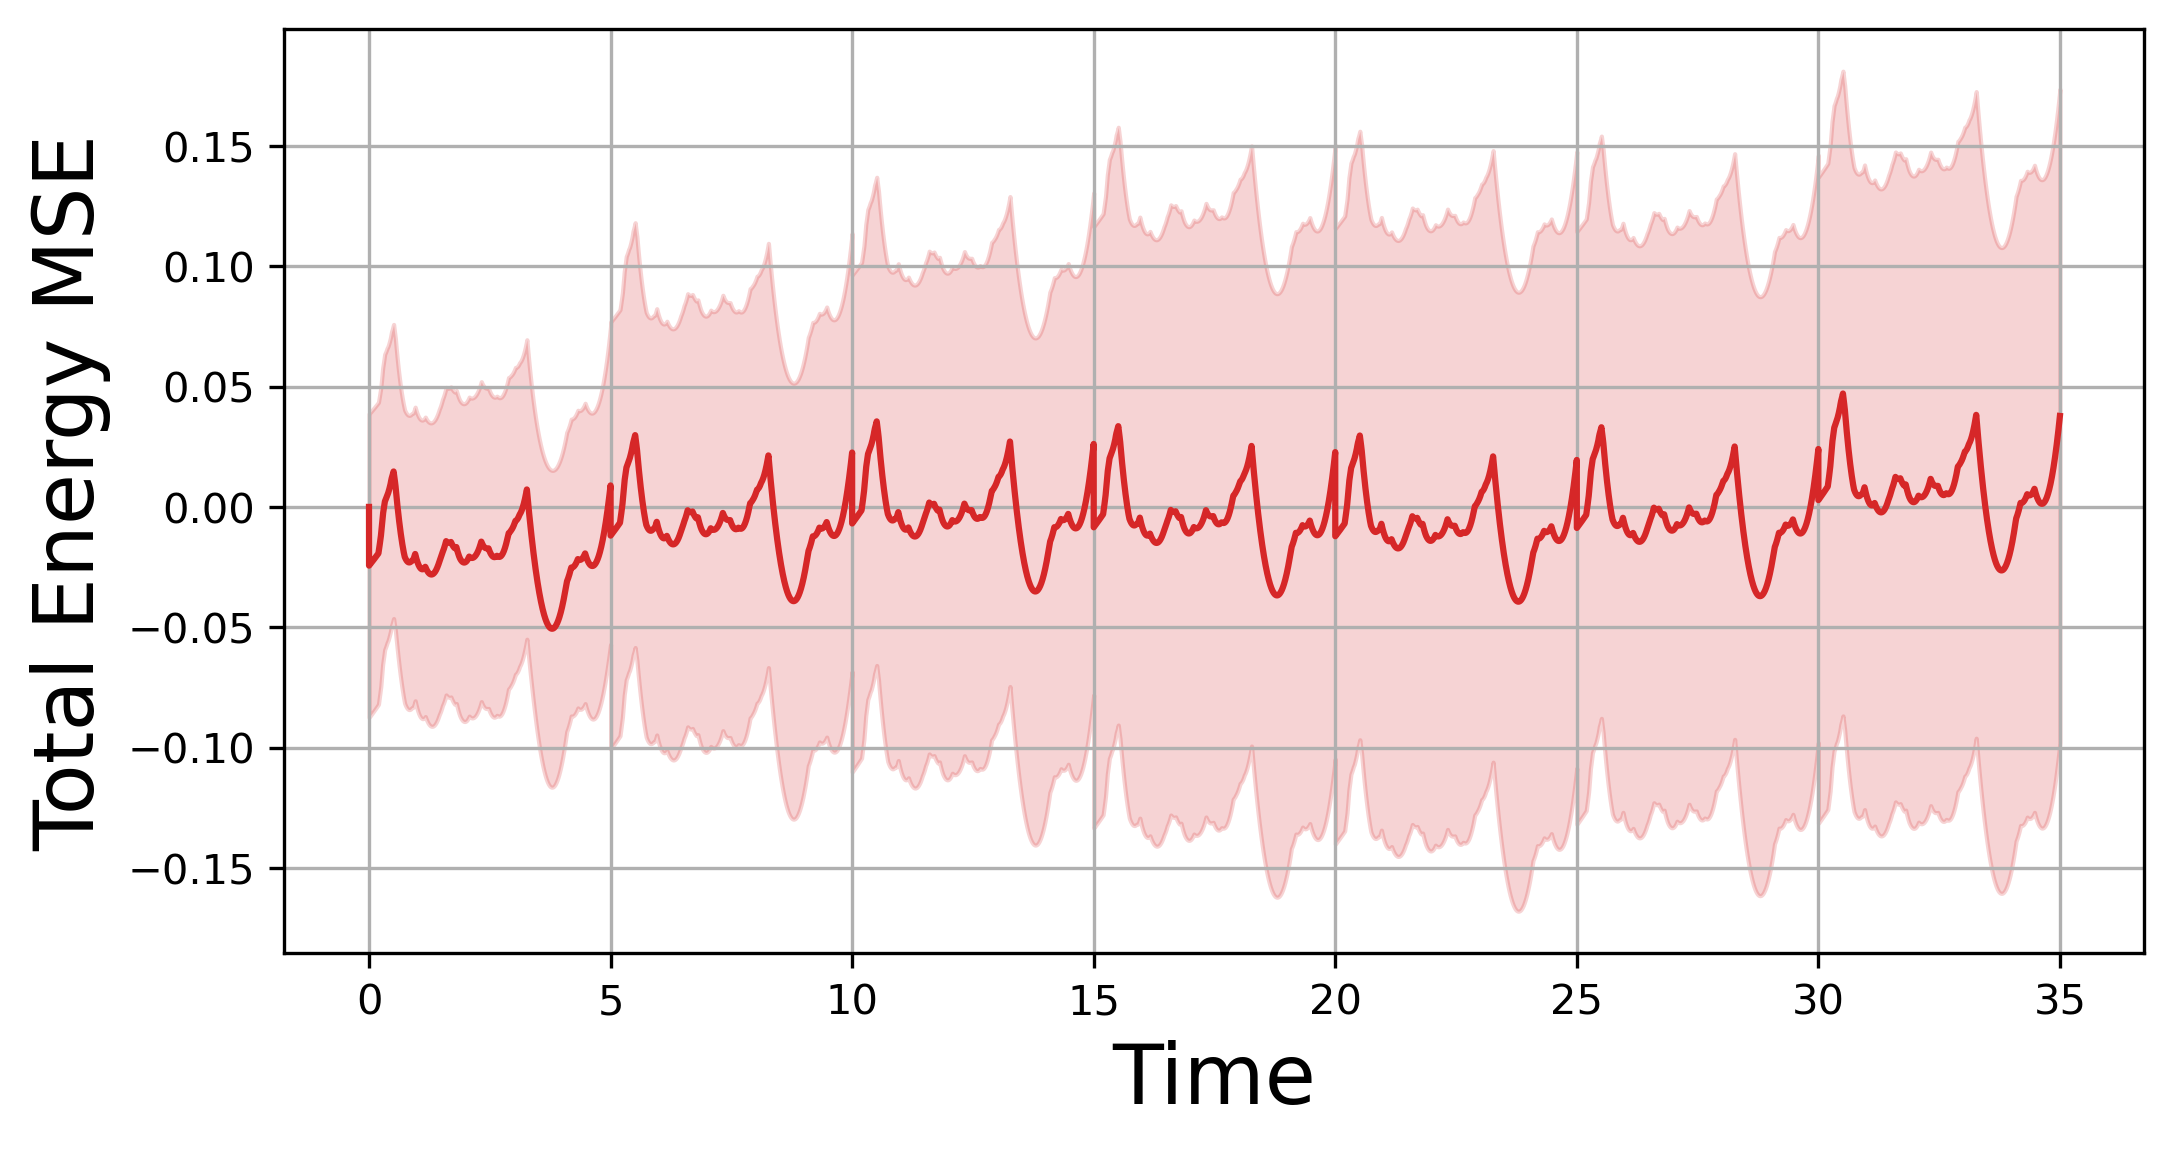

In [153]:
def plot_energy_error(preds, iv, dpi=300):
    """Plot the energy of the system (Hamiltonian) as time progresses"""
    
    torch.manual_seed(42)
    
    
    E_true = torch.linalg.norm(iv, axis=-1)**2 / 2
            
    E_preds = torch.linalg.norm(preds, axis=-1)**2 / 2
                
    E_errors = (E_preds - E_true[None,:,None]).flatten(0, 1)
        
    E_error_mean = E_errors.mean(0).detach().numpy()
    E_error_std  = E_errors.std(0).detach().numpy()
    
    # Plot both energies
    _, ax = plt.subplots(figsize=(8, 4), dpi=dpi)
    
    t = torch.linspace(0, Tmax, int(Tmax / h)+1, dtype=torch.float32)
    ax.fill_between(t, E_error_mean - E_error_std, E_error_mean + E_error_std, color='tab:red', alpha=0.2)
    ax.plot(t, E_error_mean, alpha=1, linewidth=1.5, color='tab:red')

    ax.set_xlabel("Time", fontsize="20")
    ax.set_ylabel("Total Energy MSE", fontsize="20")
    
    #ax.set_ylim(0.2481, 0.2482)
    #ax.set_yticks([0.9999, 0.99995, 1, 1.00005, 1.0001])
    ax.grid(True)
    plt.show()

plot_energy_error(preds, iv, dpi=300)

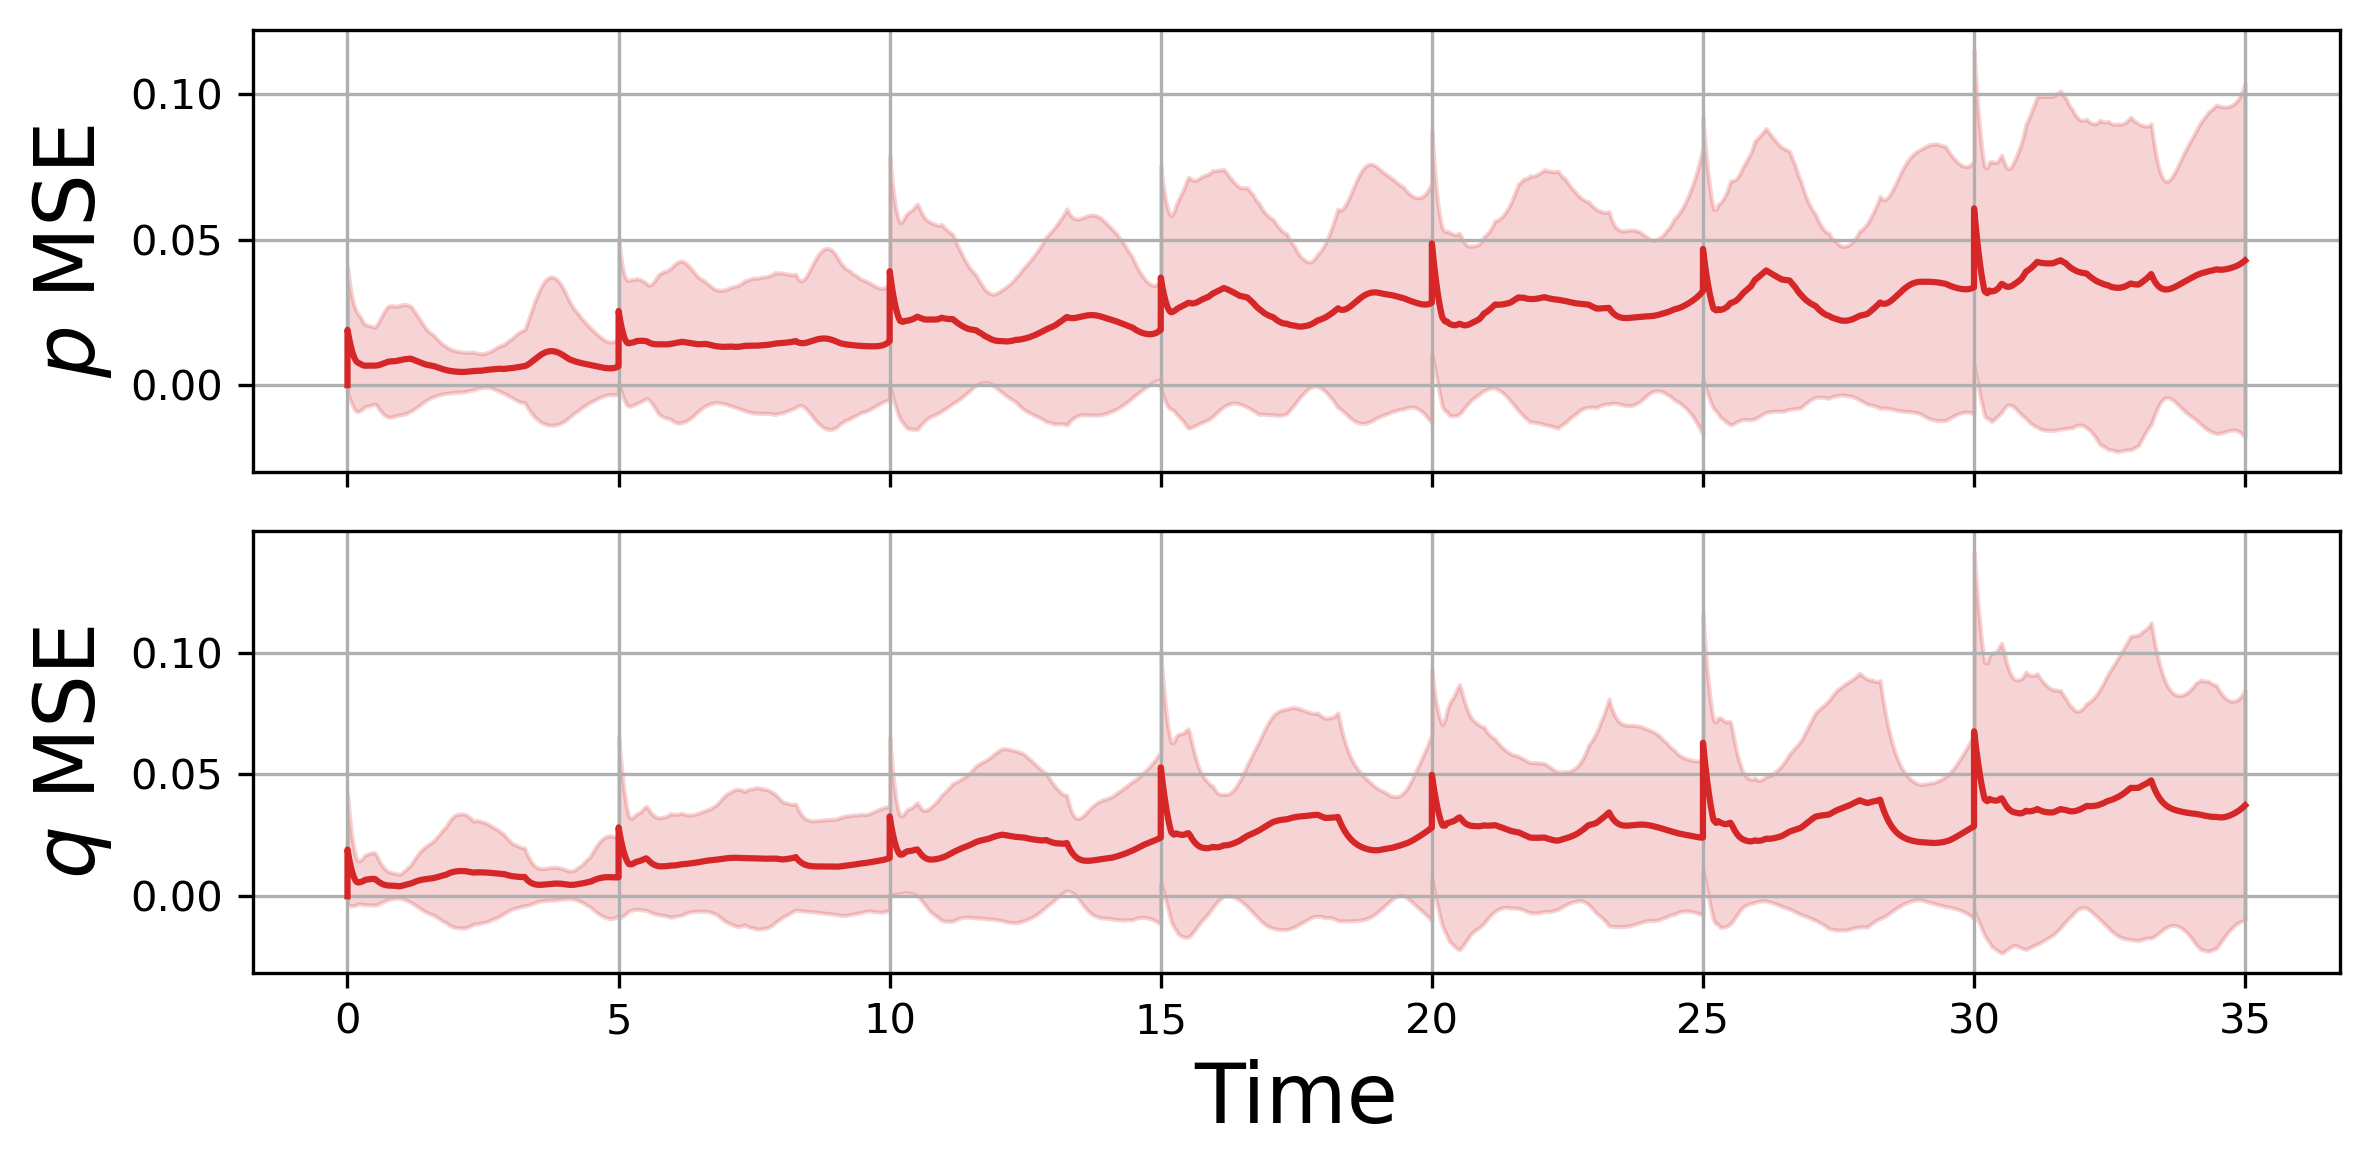

In [154]:
def plot_pred_error(preds, iv, dpi=300):
    """Plot the energy of the system (Hamiltonian) as time progresses"""
    
        
    t = torch.linspace(0, Tmax, int(Tmax / h)+1, dtype=torch.float32)
    
    true = analytic_solution(iv, t[:,None])  
    
            
    errors = (true[None,...] - preds)**2
        

    error_mean = errors.flatten(0, 1).mean(0).detach()
    error_std = errors.flatten(0, 1).std(0).detach()     
    
    # Plot both energies
    fig, ax = plt.subplots(2, 1, figsize=(8, 4), dpi=dpi, sharex=True)
    
    ax[1].set_xlabel("Time", fontsize="20")
    
    t = torch.linspace(0, Tmax, int(Tmax / h)+1, dtype=torch.float32)
    
    for i in range(2):
        
        ax[i].plot(t, error_mean[:,i], alpha=1, linewidth=1.5, color='tab:red')
        ax[i].fill_between(t, error_mean[:,i] - error_std[:,i], error_mean[:,i] + error_std[:,i], color='tab:red', alpha=0.2)
        
        m = "p" if i == 0 else "q"
        ax[i].set_ylabel(f"${m}$ MSE", fontsize="20")
        ax[i].grid(True)
        #ax.set_ylim(0.2481, 0.2482)
        #ax.set_yticks([0.9999, 0.99995, 1, 1.00005, 1.0001])


    fig.tight_layout()
    plt.show()

plot_pred_error(preds, iv, dpi=300)

TEST SYMPLECTICITY

tensor([[ 0.7254,  0.0728],
        [-0.1495,  0.5679]])
tensor([[ 0.7098, -0.0530],
        [ 0.0263,  0.8429]])
tensor([[ 0.9113, -0.0077],
        [-0.0366,  0.9477]])
tensor([[ 0.5525, -0.3882],
        [-0.0148,  0.3405]])


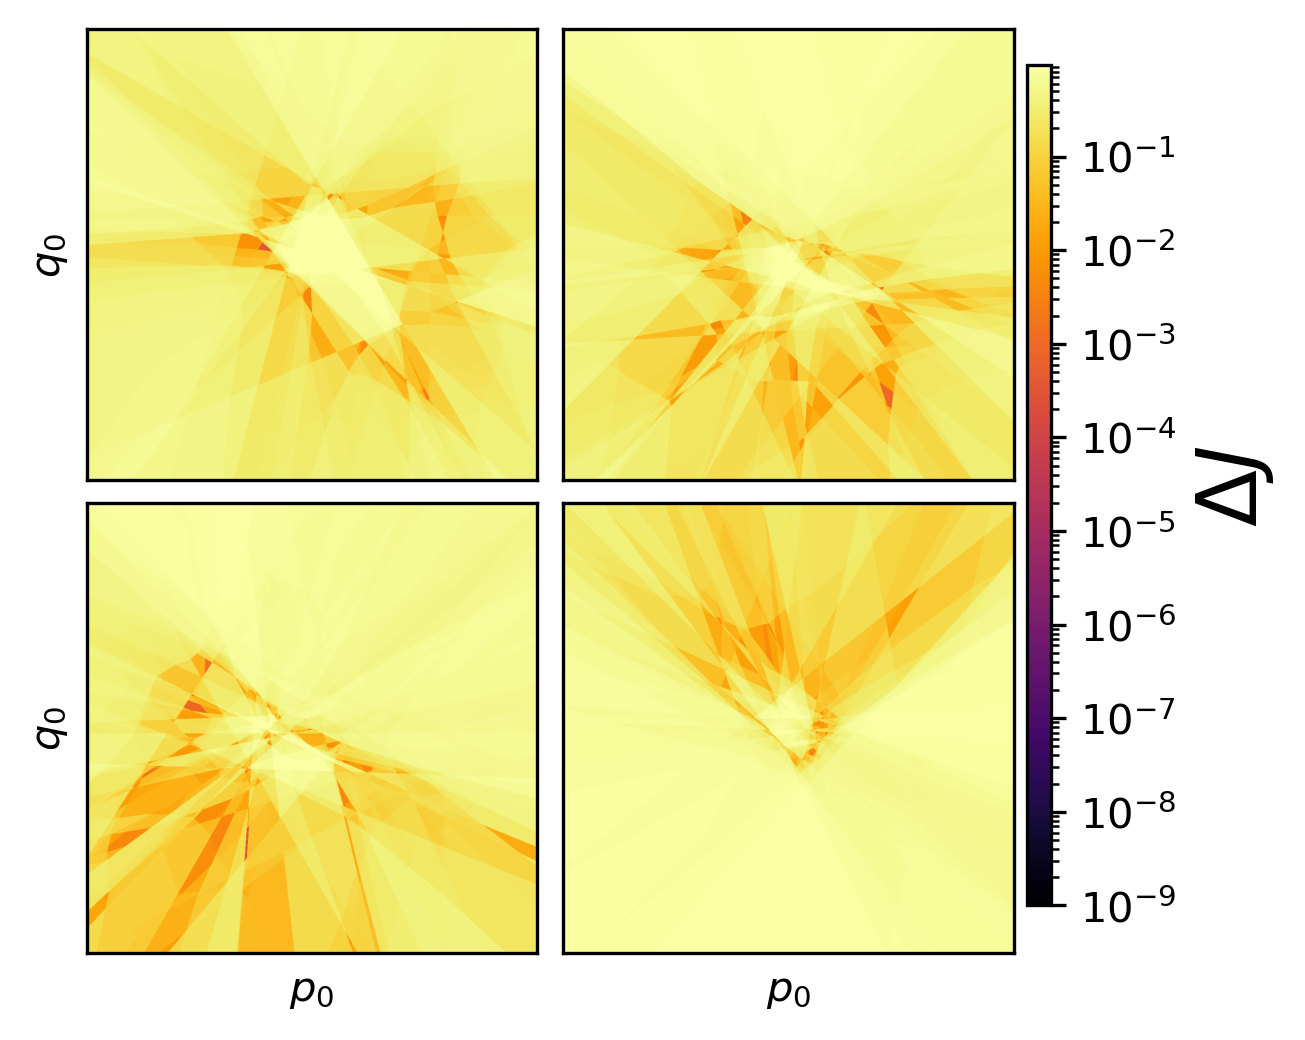

In [155]:
import matplotlib
import numpy as np

def plot_symplecticity(models, num_pts=100, dpi=300):
    """Plots how far the network is from being symplectic"""

    fig, ax = plt.subplots(2, 2, figsize=(4, 4), dpi=dpi, sharex=True, sharey=True,
                       gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.05, 'hspace': 0.05})

# Later...
    #fig.subplots_adjust(wspace=0.05, hspace=0.05, right=0.1)

    # Generate grid of initial data
    grid_points = torch.linspace(-1, 1, num_pts, requires_grad=True, dtype=torch.float32)
    mesh = torch.cartesian_prod(grid_points, grid_points)

    all_deltaJ = []
    ims = []

    for row in range(ax.shape[0]):
        for col in range(ax.shape[1]):
            idx = row * 2 + col
            model = models[idx]

            if rollout:
                X = (mesh[..., None, 0], mesh[..., None, 1])
                u = model.net(*X)
            else:
                u = model.net(mesh, torch.tensor([[h]]))[:, 0, :]

            D = torch.stack([
                grad(u[:, i], mesh, grad_outputs=torch.ones_like(u[:, i]), retain_graph=True)[0]
                for i in range(u.shape[1])
            ], axis=-1)
            
            print(D[0,...])

            J = torch.tensor([[0, 1], [-1, 0]], dtype=torch.float32)
            DTJD = D.transpose(1, 2) @ J @ D
            deltaJ = torch.linalg.norm(DTJD - J, ord=2, dim=(1, 2)).detach().numpy().reshape(num_pts, num_pts)

            all_deltaJ.append(deltaJ)

    # Compute 99th percentile for a meaningful vmax
    vmax = np.percentile(np.concatenate([d.flatten() for d in all_deltaJ]), 99)
    
    for row in range(ax.shape[0]):
        for col in range(ax.shape[1]):
            
            ax[row, col].set_yticks([])
            ax[row, col].set_xticks([])
            idx = row * 2 + col
            deltaJ = all_deltaJ[idx]
            norm = matplotlib.colors.LogNorm(vmin=1e-9, vmax=vmax)
            im = ax[row, col].imshow(deltaJ, extent=(-1, 1, -1, 1), origin='lower', cmap='inferno', norm=norm, aspect='equal')
            ims.append(im)

            if col == 0:
                ax[row, col].set_ylabel('$q_0$', fontsize=10)
                #ax[row, col].set_yticks([-1,0,1])

            if row == 1:
                ax[row, col].set_xlabel('$p_0$', fontsize=10)


    # Shared colorbar
    cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(ims[0], cax=cbar_ax)
    cbar.set_label(r"$\Delta J$", fontsize=20)

    plt.show()

plot_symplecticity(models, num_pts=1000)